# Garbage Classification
This work is the capstone project of the course 'Advanced Data Science' on Coursera. Our task is to select a dataset and use it to show the understanding of the workflow a Machine Learning project. 
In this notebook we:
* Load, explore and preprocess the data
* Define, create and train a simple Logistic Regression Model
* Define, create and train a deep Convolutional Model
* Train the Convolutional Model with normalized data
* Define, calculate and explain different metrics to evaluate the performance of each model

The dataset is called 'Garbage Classification' ([https://www.kaggle.com/asdasdasasdas/garbage-classification/](http://)) and contains images of different kind of garbage, our goal is to correctly identify each image.

In [2]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

## Data Loading

Let's load the dataset and start exploring its features.

In [3]:
BASE_DIR = 'datasets'
IMG_DIR = f'{BASE_DIR}/Garbage classification'

path_list = glob.glob(os.path.join(IMG_DIR, '*/*.jpg'))
num_samples = len(path_list)
print(f'Found {num_samples} images')

Found 2527 images


The dataset contains of 2527 images from 6 different classes: *cardboard*, *glass*, *metal*, *paper*, *plastic* and *trash*. The images are 3 channels RGB with shape 512 × 384, but for our purposes they will be cropped to be square with dimension 384 × 384.

#### Data Augmentation
Since the dataset is relatively small we decided not to split into train, validation and test images beforehand. In fact, this will reduce the dataset size even more which could easily lead to overfitting. Instead we keep 10% as validation data and the rest is used for training, and to increase the performance on new samples, we will augment the training dataset by: flipping, zooming, shearing and shifting the images. This also should help prevent overfitting and give us the opportunity to build a deeper model.

In [4]:
from keras.preprocessing.image import ImageDataGenerator

img_size = (384, 384)
batch_size = 32

tr=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1)

val=ImageDataGenerator(validation_split = 0.1)

train_generator=tr.flow_from_directory(IMG_DIR,
                                       target_size=img_size,
                                       batch_size=batch_size,
                                       class_mode='categorical',
                                       subset='training')

val_generator=val.flow_from_directory(IMG_DIR,
                                      target_size=img_size,
                                      batch_size=batch_size,
                                      class_mode='categorical',
                                      subset='validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


#### Balance Dataset

This dataset is not balanced, meaning that there are different numbers of samples for each category. This could lead to inaccuracies during the training phase as the model will be biased towards predicting the classes which occur more. 

In [5]:
import pandas as pd

samples = pd.read_csv(f'{BASE_DIR}/zero-indexed-files.txt', sep = ' ', names = ['path', 'label'])
unique, counts = np.unique(samples['label'], return_counts=True)

class_to_id = train_generator.class_indices
id_to_class = {k: v for v, k in class_to_id.items()}
print('Number of samples: ')
for count, category in zip(counts, class_to_id.keys()):
    print(f'{count} in {category}')

Number of samples: 
501 in cardboard
594 in glass
403 in metal
482 in paper
410 in plastic
137 in trash


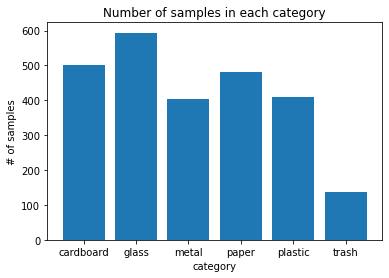

In [6]:
plt.bar(list(class_to_id.keys()), counts) 
plt.title('Number of samples in each category') 
plt.xlabel('category') 
plt.ylabel('# of samples') 
plt.show()

As we can clearly see there is a relevant imbalance between the number of samples in the category "trash" and the others. To present less biased data to our model, we calculate <code> class_weigths </code> which we will pass to our <code> fit </code> function during the training phase. This will ensure that the frequency of occurence for samples of each class is equal to the others.

In [7]:
weights = [(1 / category_count) * (num_samples) / len(unique) for category_count in counts]
class_weights = {k: v for k, v in zip(unique, weights)}
class_weights

{0: 0.8406520292747838,
 1: 0.7090347923681257,
 2: 1.0450785773366418,
 3: 0.873789764868603,
 4: 1.0272357723577235,
 5: 3.0742092457420926}

These weights are inversely proportional to the size of each class and will smooth out the difference in occurence frequency.

### Show some samples

This is one of the samples which we will work with.

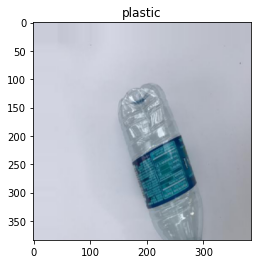

In [8]:
x, y = train_generator.next()
category = np.argmax(y[0])

plt.title(id_to_class[category])
plt.imshow((x[0]).astype('int'))
plt.show()

# Models

## Logistic Regression model

We now build the first model. It is a simple Logistic Regression Model with one hidden layer with 6 neurons. The chosen activation function is ***softmax*** in order to return a confidence score for the prediction.

In [9]:
from keras import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint


def logistic_regression_model():
    
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(6,activation='softmax'))
    
    return model

### Define training function

In [10]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

def train(model, train_gen, val_gen, epochs, best_model_name='best_model.h5'):
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    
    checkpoint = ModelCheckpoint(best_model_name, 
                                 monitor='val_acc', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='max')
    
    reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                                  mode='max')
    
    history = model.fit(train_gen,
                        epochs=epochs,
                        validation_data=val_gen,
                        class_weight=class_weights, 
                        workers = 4,
                        callbacks=[checkpoint, reduce_lr])
    return history

### Compile and train the model

Since the model is shallow, 20 epochs are enough to train the model and prevent overfitting

In [11]:
lr = logistic_regression_model()
lr_history = train(lr, train_generator, val_generator, epochs = 20, best_model_name = 'best_simple_model.h5')

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 34663.3672 - acc: 0.2140
Epoch 00001: val_acc improved from -inf to 0.26693, saving model to best_simple_model.h5
72/72 [==============================] - 81s 1s/step - loss: 34663.3672 - acc: 0.2140 - val_loss: 7593.3906 - val_acc: 0.2669
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 17100.2676 - acc: 0.2438
Epoch 00002: val_acc improved from 0.26693 to 0.29084, saving model to best_simple_model.h5
72/72 [==============================] - 82s 1s/step - loss: 17100.2676 - acc: 0.2438 - val_loss: 11652.9092 - val_acc: 0.2908
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 8300.9717 - acc: 0.2882
Epoch 00003: val_acc improved from 0.29084 to 0.35060, saving model to best_simple_model.h5
72/72 [==============================] - 81s 1s/step - loss: 8300.9717 - acc: 0.2882 - val_loss: 4580.7803 - val_acc: 0.3506
Epoch 4/20
72/72 [==============================] - ETA: 0s - loss: 112

### Results analysis: Logistic Regression

The first step to get an idea about the capabilities of the model is to see the accuracy and the loss during the training and validation phase. This way, we can detect overfitting at a glance and determine if the lerning rate and the number of epochs were adequate.

In [11]:
def plot_history(history):
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot accuracy 
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,max(plt.ylim())])
    plt.title('Loss')
    plt.show()

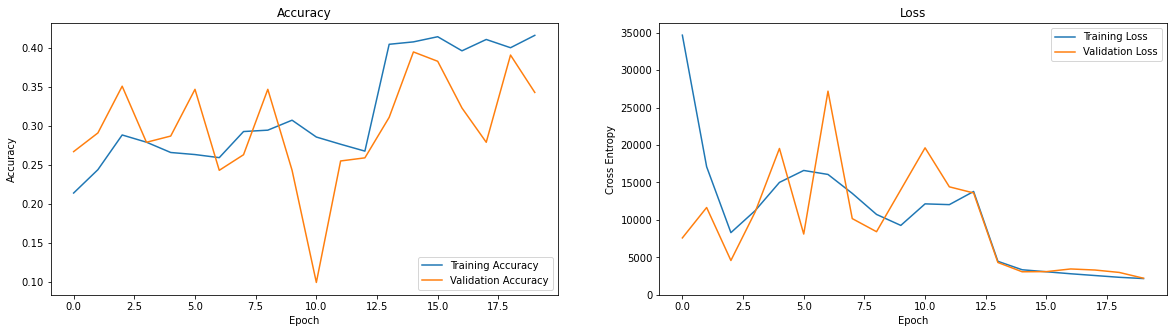

In [13]:
plot_history(lr_history)

We can then evaluate the model using different metrics, in this case we used the **confusion matrix** and the **F1 score**.

Since the dataset is quite small, we will use it as a whole to make the predictions. This could lead to inaccurate results in case of overfitting, but since we augmented the dataset in the training phase, we prevent this situation to occur.

In [12]:
test_generator = ImageDataGenerator().flow_from_directory(IMG_DIR,
                                        target_size=img_size,
                                        batch_size=1,
                                        class_mode='categorical')

Found 2527 images belonging to 6 classes.


Let's define a function which returns the true labels and the predictions and store them in <code> ys </code> and <code> preds </code>.

In [13]:
def evaluate(m, test_gen):
    preds = []
    ys = []
    for i in range(len(test_generator)):
        pred = np.argmax(m.predict(test_gen[i][0]))
        preds.append(pred)
        y = np.argmax(test_gen[i][1])
        ys.append(y)
    return ys, preds

In [16]:
lr_ys, lr_preds = evaluate(lr, test_genenerator)

#### Confusion matrix
The **confusion matrix** contains the predicted classes as rows, and the target classes as columns. This way, we can see which classes the model predicts best and which one it struggles with. We want to maximise the elements on the diagonal as they are the correct predictions.

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

def confusion(ys, preds):
    matrix = confusion_matrix(ys, preds)
    sn.heatmap(matrix, annot=True)

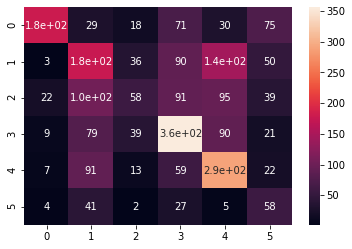

In [18]:
confusion(lr_ys, lr_preds)

#### F1 Score

The **F1 score** is defined as $$2*\frac{precision * recall} {precision + recall}$$ where $$precision = \frac{True\ Positives}{True\ Positives + False\ Positives} \hspace{1cm} recall = \frac{True\ Positives}{True\ Positives + False\ Negatives}$$
<br>This score balances the measure of the exactness ( $precision$ ) and completeness ( $recall$ ) of the model and the closer to $1$ it is, the better the model performance.

In [16]:
from sklearn.metrics import f1_score

def f1(ys, preds):
    score = f1_score(ys, preds, average='weighted')
    print(f'F1 score is: {score}')
    return score

In [20]:
f1_lr = f1(lr_ys, lr_preds)

F1 score is: 0.4355848113706974


## Convolutional Model

Let's build the second model. It has 4 convolutional layers and MaxPooling layers which constitute convolutional section of the model, where the features are extracted from the images. Then 3 fully connected layers with Dropout make up the classificsation section, these layers will classify the images based on the feature previously extracted. 

In [17]:
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout


def CNN_model():
    
    model = Sequential()
    
    #Convolutional layers
    model.add(Conv2D(16,(3,3), padding='same',activation='relu', input_shape=(*img_size,3)))
    model.add(MaxPooling2D(pool_size=2)) 

    model.add(Conv2D(32,(3,3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=2)) 

    model.add(Conv2D(64,(3,3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=2)) 

    model.add(Conv2D(32,(3,3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=2)) 

    #Classification layers
    model.add(Flatten())

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(6,activation='softmax'))
    
    return model

### Train convolutional model

In [23]:
cnn = CNN_model()
cnn_history = train(cnn, train_generator, val_generator, epochs = 80, best_model_name='best_cnn_model.h5')

Epoch 1/80
72/72 [==============================] - ETA: 0s - loss: 5.9379 - acc: 0.2017
Epoch 00001: val_acc improved from -inf to 0.24701, saving model to best_cnn_model.h5
72/72 [==============================] - 76s 1s/step - loss: 5.9379 - acc: 0.2017 - val_loss: 1.7731 - val_acc: 0.2470
Epoch 2/80
72/72 [==============================] - ETA: 0s - loss: 1.7993 - acc: 0.2399
Epoch 00002: val_acc improved from 0.24701 to 0.31076, saving model to best_cnn_model.h5
72/72 [==============================] - 80s 1s/step - loss: 1.7993 - acc: 0.2399 - val_loss: 1.7631 - val_acc: 0.3108
Epoch 3/80
72/72 [==============================] - ETA: 0s - loss: 1.7598 - acc: 0.2922
Epoch 00003: val_acc did not improve from 0.31076
72/72 [==============================] - 82s 1s/step - loss: 1.7598 - acc: 0.2922 - val_loss: 1.7848 - val_acc: 0.2311
Epoch 4/80
72/72 [==============================] - ETA: 0s - loss: 1.7896 - acc: 0.2192
Epoch 00004: val_acc did not improve from 0.31076
72/72 [=====

Epoch 32/80
72/72 [==============================] - ETA: 0s - loss: 1.2315 - acc: 0.5062
Epoch 00032: val_acc did not improve from 0.48207
72/72 [==============================] - 73s 1s/step - loss: 1.2315 - acc: 0.5062 - val_loss: 1.2507 - val_acc: 0.4622
Epoch 33/80
72/72 [==============================] - ETA: 0s - loss: 1.2003 - acc: 0.5158
Epoch 00033: val_acc improved from 0.48207 to 0.49402, saving model to best_cnn_model.h5
72/72 [==============================] - 73s 1s/step - loss: 1.2003 - acc: 0.5158 - val_loss: 1.2528 - val_acc: 0.4940
Epoch 34/80
72/72 [==============================] - ETA: 0s - loss: 1.2471 - acc: 0.5136
Epoch 00034: val_acc did not improve from 0.49402
72/72 [==============================] - 74s 1s/step - loss: 1.2471 - acc: 0.5136 - val_loss: 1.3693 - val_acc: 0.4502
Epoch 35/80
72/72 [==============================] - ETA: 0s - loss: 1.1685 - acc: 0.5272
Epoch 00035: val_acc improved from 0.49402 to 0.49801, saving model to best_cnn_model.h5
72/72

Epoch 64/80
72/72 [==============================] - ETA: 0s - loss: 1.0750 - acc: 0.5773
Epoch 00064: val_acc did not improve from 0.56175
72/72 [==============================] - 77s 1s/step - loss: 1.0750 - acc: 0.5773 - val_loss: 1.1754 - val_acc: 0.5538
Epoch 65/80
72/72 [==============================] - ETA: 0s - loss: 0.9867 - acc: 0.6125- ETA: 9s - loss: 0.9992 - acc
Epoch 00065: val_acc improved from 0.56175 to 0.58167, saving model to best_cnn_model.h5
72/72 [==============================] - 76s 1s/step - loss: 0.9867 - acc: 0.6125 - val_loss: 1.0773 - val_acc: 0.5817
Epoch 66/80
72/72 [==============================] - ETA: 0s - loss: 1.0083 - acc: 0.6195
Epoch 00066: val_acc did not improve from 0.58167
72/72 [==============================] - 76s 1s/step - loss: 1.0083 - acc: 0.6195 - val_loss: 1.1478 - val_acc: 0.5378
Epoch 67/80
72/72 [==============================] - ETA: 0s - loss: 0.9965 - acc: 0.6164
Epoch 00067: val_acc did not improve from 0.58167
72/72 [=======

### Results analysis: Convolutional model.

In order to get consistent results we evaluate the performance of the convolutional model with use the same metrics as the logistic regression model. So we plot accuracy and loss and calculate confusion matrix and F1 score.

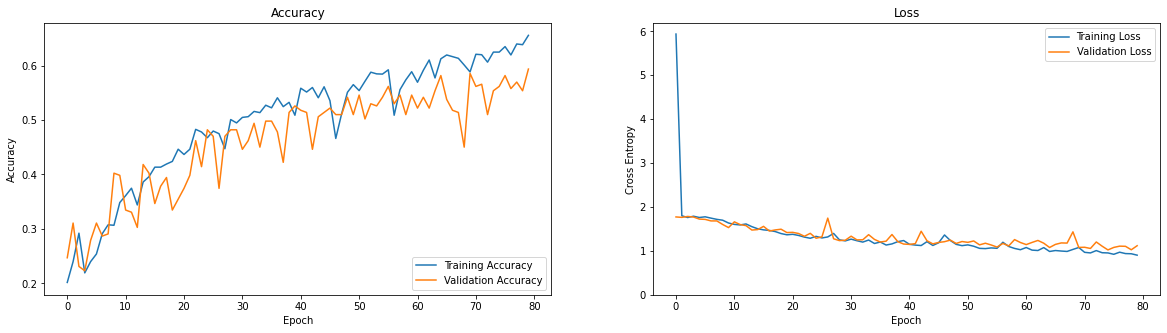

In [24]:
plot_history(cnn_history)

Let's make the predictions

In [33]:
cnn_ys, cnn_preds = evaluate(cnn, test_generator)

#### Confusion matrix

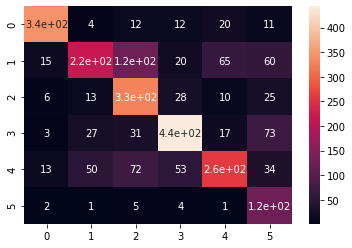

In [34]:
confusion(cnn_ys, cnn_preds)

#### F1 score

In [35]:
f1_cnn = f1(cnn_ys, cnn_preds)

F1 score is: 0.6792687080815812


### Train the model with data normalization.
In order to get better results a good strategy is to normalize the input. In this case we restrict all values in the interval $ [0, 1]$.
Having similar distribution between samples ensures a faster convergence during training and avoids the vanishing gradient problem, which can slow down or halt the training process. By limiting values the gradient also remains bounded, thus avoiding also exploding gradient.
We perform a new training on the Convolutional Model with normalized data and then compare the results.

In [20]:
tr.rescale = 1./255
val.rescale = 1./255

train_norm_generator = tr.flow_from_directory(IMG_DIR,
                                          target_size=img_size,
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset='training')

val_norm_generator=val.flow_from_directory(IMG_DIR,
                                        target_size=img_size,
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        subset='validation')

test_norm_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(IMG_DIR,
                                        target_size=img_size,
                                        batch_size=1,
                                        class_mode='categorical')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.


In [22]:
cnn_norm = CNN_model()
cnn_norm_history = train(cnn_norm, train_norm_generator, val_norm_generator, epochs = 80, best_model_name='best_cnn_model_norm.h5')

Epoch 1/80
72/72 [==============================] - ETA: 0s - loss: 1.7758 - acc: 0.2272
Epoch 00001: val_acc improved from -inf to 0.29084, saving model to best_cnn_model_norm.h5
72/72 [==============================] - 84s 1s/step - loss: 1.7758 - acc: 0.2272 - val_loss: 1.6933 - val_acc: 0.2908
Epoch 2/80
72/72 [==============================] - ETA: 0s - loss: 1.6869 - acc: 0.2935
Epoch 00002: val_acc improved from 0.29084 to 0.35060, saving model to best_cnn_model_norm.h5
72/72 [==============================] - 82s 1s/step - loss: 1.6869 - acc: 0.2935 - val_loss: 1.6204 - val_acc: 0.3506
Epoch 3/80
72/72 [==============================] - ETA: 0s - loss: 1.5657 - acc: 0.3572
Epoch 00003: val_acc improved from 0.35060 to 0.38645, saving model to best_cnn_model_norm.h5
72/72 [==============================] - 84s 1s/step - loss: 1.5657 - acc: 0.3572 - val_loss: 1.4723 - val_acc: 0.3865
Epoch 4/80
72/72 [==============================] - ETA: 0s - loss: 1.4932 - acc: 0.4165
Epoch 00

Epoch 31/80
72/72 [==============================] - ETA: 0s - loss: 0.9426 - acc: 0.6529
Epoch 00031: val_acc did not improve from 0.65737
72/72 [==============================] - 87s 1s/step - loss: 0.9426 - acc: 0.6529 - val_loss: 1.0255 - val_acc: 0.6056
Epoch 32/80
72/72 [==============================] - ETA: 0s - loss: 0.8754 - acc: 0.6709
Epoch 00032: val_acc did not improve from 0.65737
72/72 [==============================] - 88s 1s/step - loss: 0.8754 - acc: 0.6709 - val_loss: 1.0610 - val_acc: 0.5936
Epoch 33/80
72/72 [==============================] - ETA: 0s - loss: 0.8544 - acc: 0.6863
Epoch 00033: val_acc improved from 0.65737 to 0.66135, saving model to best_cnn_model_norm.h5
72/72 [==============================] - 87s 1s/step - loss: 0.8544 - acc: 0.6863 - val_loss: 0.8511 - val_acc: 0.6614
Epoch 34/80
72/72 [==============================] - ETA: 0s - loss: 0.8379 - acc: 0.6863
Epoch 00034: val_acc did not improve from 0.66135
72/72 [==============================] 

Epoch 62/80
72/72 [==============================] - ETA: 0s - loss: 0.5729 - acc: 0.7917
Epoch 00062: val_acc improved from 0.70916 to 0.72112, saving model to best_cnn_model_norm.h5
72/72 [==============================] - 90s 1s/step - loss: 0.5729 - acc: 0.7917 - val_loss: 0.7919 - val_acc: 0.7211
Epoch 63/80
72/72 [==============================] - ETA: 0s - loss: 0.5591 - acc: 0.7904
Epoch 00063: val_acc did not improve from 0.72112
72/72 [==============================] - 88s 1s/step - loss: 0.5591 - acc: 0.7904 - val_loss: 0.7864 - val_acc: 0.7131
Epoch 64/80
72/72 [==============================] - ETA: 0s - loss: 0.5492 - acc: 0.8018
Epoch 00064: val_acc did not improve from 0.72112
72/72 [==============================] - 89s 1s/step - loss: 0.5492 - acc: 0.8018 - val_loss: 0.7688 - val_acc: 0.7171
Epoch 65/80
72/72 [==============================] - ETA: 0s - loss: 0.5395 - acc: 0.8005
Epoch 00065: val_acc did not improve from 0.72112
72/72 [==============================] 

### Results analysis: Convolutional model with normalization

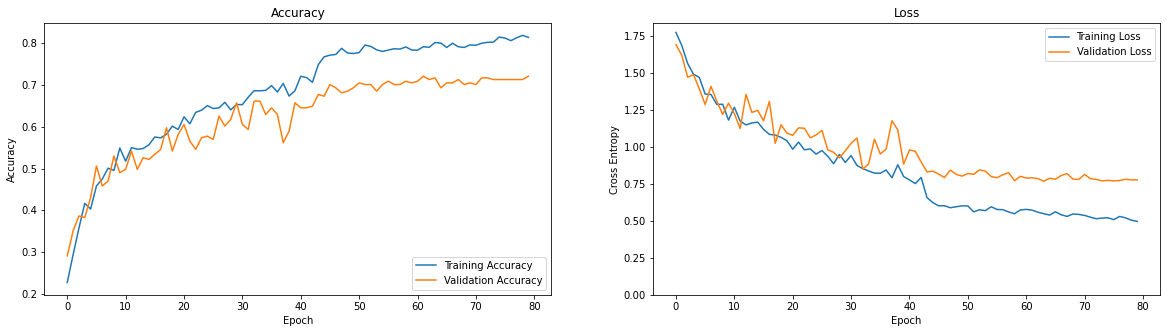

In [23]:
plot_history(cnn_norm_history)

Let's make the predictions

In [24]:
cnn_norm_ys, cnn_norm_preds = evaluate(cnn_norm, test_norm_generator)

#### Confusion matrix

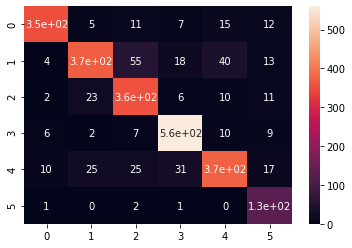

In [26]:
confusion(cnn_norm_ys, cnn_norm_preds)

#### F1 Score

In [27]:
f1_cnn_norm = f1(cnn_norm_ys, cnn_norm_preds)

F1 score is: 0.850071763744821


# Conclusions

Finally let's plot the F1 scores for the three different models

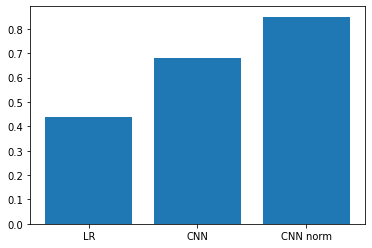

In [28]:
plt.bar(['LR', 'CNN', 'CNN norm'], [f1_lr, f1_cnn, f1_cnn_norm])
plt.show()

We achieved a final F1 score of 0.85 with the Convolutional model with normalized data. Compared to the Convolutional model with non normalized data shows a 27% improvement and compared to the simple Logistic Regression model a 97% improvement. This shows that feature engineering and model selection are cornerstones of the machine learning workflow and it's important to focus thoroughly and do plenty of testing before deciding.